# Hedging climate risk (inspired by Engle et al. (2020))

## Table of Contents

- [Overview](#overview)
- [Installation](#installation)
- [Usage](#usage)
- [Results](#results)
- [License](#license)

<br>

#### **Overview**
This notebook first parses around 30.000 transcripts from firms' earnings calls published between 2009 and 2025. 


- It saves all relevant information in JSON files in the folder:
``` console
/Users/marleendejonge/Desktop/PhD/Projects/ECC transcripts/data/structured_jsons/BERT
``` 
- Then, ClimateBERT is used to classify all climate-related paragraphs within the earning call's management section. All relevant data is then saved in:
``` console
/Users/marleendejonge/Desktop/PhD/Projects/ECC transcripts/data/climate_segments/BERT
``` 
- Based on the identified climate-related passages, a ratio is calculated of the total discussion on climate-related passages to the total discussion. We visualize these ratios over time and over different firm locations.
- Subsequently, we use these climate ratios as proxy for climate risk exposure and use it to replicate the hedging method from **Engle et al. (2020)**


#### **Installation**
`pip install -r requirements.txt`

#### **Usage**
To replicate full results use `run all`, to run specific part of the analyis run the cells below a specific header

#### **Results (preliminary)**
...

#### **License**
Marleen de Jonge @ University of Amsterdam

In [1]:
root_code = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/code/"
root_data = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/"

In [2]:
import os

from preprocessing.load_transcripts import find_and_delete_duplicate_filenames, extract_transcripts
from preprocessing.parse_data import structure_all_transcripts_from_parts
from preprocessing.parser import process_all_pdfs_in_directory

import re
from datetime import datetime
import pandas as pd
from climate_variables.gen_climate_embeddings import generate_climate_embeddings
from engle.Z_clim import clim_matrix
from utils.lookup import get_climate_texts, load_climate_data_with_source, build_lookup

🔹 Loading spaCy model...
✅ spaCy model loaded successfully!


### Preprocessing

#### Choose either SP500 or STOXX600

In [3]:
STOCK_INDEX = 'STOXX600'

#### Check if duplicate files occur

In [4]:
pdf_folder = root_data + f"FactSet Transcripts/{STOCK_INDEX}"

duplicates = find_and_delete_duplicate_filenames(pdf_folder, delete=True)

if duplicates:
    print(f"Found {len(duplicates)} duplicate filenames:")
    for d in duplicates:
        print(" -", d)
else:
    print("✅ No duplicate filenames found.")

Checking & deleting duplicates: 0folder [00:00, ?folder/s]


🗑️ Deleted 0 duplicate files (keeping one copy of each).
✅ No duplicate filenames found.


#### Extract text from PDFs and save to JSON files

_This takes about 13 minutes._

**Input**: the folders containing all the transcript pdfs. <br>
**Output**: one json file per folder saving the filename and separated management and Q&A section

In [ ]:
output_file_base = root_data + f"raw_data_jsons/{STOCK_INDEX}/transcripts_data"

extract_transcripts(
    pdf_root_folder=pdf_folder,
    output_basename=output_file_base,
    num_parts=15
)

_This takes about 60 minutes._

**Input**: the raw data jsons from [this folder](../../ECC%20transcripts/data/raw_data_jsons) <br>
**Output**: 15 equally sized structured jsons located [here](../../ECC%20transcripts/data/structured_jsons/BERT) where metadata of the call is saved and the tekst is split into paragraphs _

In [ ]:
input_folder = root_data+f"raw_data_jsons/{STOCK_INDEX}"  # Folder with all the transcript_data_part*.json files
output_folder = root_data+f"structured_jsons/BERT/{STOCK_INDEX}"

structure_all_transcripts_from_parts(
    input_folder=input_folder,
    output_folder=output_folder
)

### Go to run_all.py

After finishing the climate passage identification, run the cells below

In [ ]:
process_all_pdfs_in_directory(f'{root_data}structured_jsons/BERT/{STOCK_INDEX}', f'{root_data}FactSet Transcripts/{STOCK_INDEX}', index='STOXX600')

In [ ]:
process_all_pdfs_in_directory(f'{root_data}climate_segments/BERT/{STOCK_INDEX}', f'{root_data}FactSet Transcripts/{STOCK_INDEX}', index='STOXX600')

## Ratio-based climate risk

### Classifying climate-related passages with ClimateBERT

In [5]:
import os

from climate_variables.climate_ratio_calculator import compute_climate_sentence_ratio

import pandas as pd

root_code = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/code/"
root_data = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/"

To identify climate-related passages with ClimateBERT, first split the JSONs that need to be processed over [terminal 1](../../ECC%20transcripts/data/structured_jsons/BERT/terminal_1/) and [terminal 2](../../ECC%20transcripts/data/structured_jsons/BERT/terminal_2/)

Then, open the terminal and run:
```console
(ECC) marleendejonge@Marleens-MacBook-Pro ECC transcripts % python scripts/run_all.py
```

### Calculate ratios of climate-related discussion

#### Load

In [12]:
df_ratio = pd.read_csv(f"{root_data}clim_metrics/ratio/BERT/climate_sentence_ratio_output-0.csv")

#### Or calculate

In [3]:
df_ratio = compute_climate_sentence_ratio(root_data, model_name="BERT", indices=['SP500', 'STOXX600'])

Processing index: SP500


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [01:03<00:00,  3.32s/it]


Processing index: STOXX600


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


#### Check if the ratios make sense

In [13]:
df_ratio.head()

,file,name,climate_sentence_count,management_sentence_count,ratio,year,quarter,ticker,date,climate_json_file,structured_json_file
0,CORRECTED TRANSCRIPT The Home Depot IncHDUS Q1...,"The Home Depot, Inc. (HD)",22,142,0.154930,2015.0,Q1,HD,2015-05-19,climate_segments_16.json,structured_calls_16_d.json
1,CORRECTED TRANSCRIPT Paychex IncPAYXUS Q3 2010...,"Paychex, Inc.",0,171,0.000000,2010.0,Q3,PAYX,2010-03-26,climate_segments_1.json,structured_calls_1_d.json
2,CORRECTED TRANSCRIPT Fair Isaac CorpFICOUS Q1 ...,Fair Isaac Corp.,0,165,0.000000,2010.0,Q1,FICO,2010-01-27,climate_segments_1.json,structured_calls_1_d.json
3,CORRECTED TRANSCRIPT Fifth Third BancorpFITBUS...,Fifth Third Bancorp (FITB),0,311,0.000000,2011.0,Q2,FITB,2011-07-21,climate_segments_1.json,structured_calls_1_d.json
4,CORRECTED TRANSCRIPT Norfolk Southern CorpNSCU...,Norfolk Southern Corp.,45,187,0.240642,2010.0,Q3,NSC,2010-10-27,climate_segments_1.json,structured_calls_1_d.json


9940 over 29440 have a ratio of 0 (33%)

In [36]:
df_ratio.loc[df_ratio.ticker == 'A']

,file,name,climate_sentence_count,management_sentence_count,ratio,year,quarter,ticker,date,climate_json_file,structured_json_file
1883,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",22,178,0.123596,2016,Q4,A,2016-11-15,climate_segments_17.json,structured_calls_17_d.json
1948,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",16,150,0.106667,2014,Q3,A,2014-08-14,climate_segments_17.json,structured_calls_17_d.json
1976,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",7,179,0.039106,2017,Q4,A,2017-11-20,climate_segments_17.json,structured_calls_17_d.json
2007,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc.",7,171,0.040936,2010,Q2,A,2010-05-17,climate_segments_17.json,structured_calls_17_d.json
2046,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",16,108,0.148148,2015,Q3,A,2015-08-17,climate_segments_17.json,structured_calls_17_d.json
...,...,...,...,...,...,...,...,...,...,...,...
25652,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",15,131,0.114504,2016,Q1,A,2016-02-16,climate_segments_18.json,structured_calls_18_d.json
25709,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",25,137,0.182482,2014,Q2,A,2014-05-14,climate_segments_18.json,structured_calls_18_d.json
27758,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",11,181,0.060773,2021,Q4,A,2021-11-23,climate_segments_15.json,structured_calls_15_d.json
28059,CORRECTED TRANSCRIPT Agilent Technologies IncA...,"Agilent Technologies, Inc. (A)",12,179,0.067039,2021,Q2,A,2021-05-25,climate_segments_15.json,structured_calls_15_d.json


In [15]:
df_ratio.date = pd.to_datetime(df_ratio.date)

##### Some statistics...

In [16]:
df_ratio['year'] = df_ratio.date.dt.year

In [17]:
num_years = df_ratio['year'].nunique()
print("Number of unique years:", num_years, "\n")

print("Years covered:", sorted(df_ratio.date.dt.year.unique()), "\n")

num_tickers = df_ratio['ticker'].nunique()
print("Number of unique tickers:", num_tickers, "\n")

tickers_per_year = df_ratio.groupby('year')['ticker'].nunique()
print("Tickers observed per year:")
print(tickers_per_year, "\n")

Number of unique years: 17 

Years covered: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025] 

Number of unique tickers: 581 

Tickers observed per year:
year
2009    110
2010    435
2011    443
2012    452
2013    463
2014    474
2015    475
2016    476
2017    488
2018    482
2019    487
2020    489
2021    490
2022    493
2023    496
2024    487
2025    152
Name: ticker, dtype: int64 



### Visualize exposures

In [18]:
from utils.ratio_explorer import plot_climate_ratio_over_time

#### Show time series

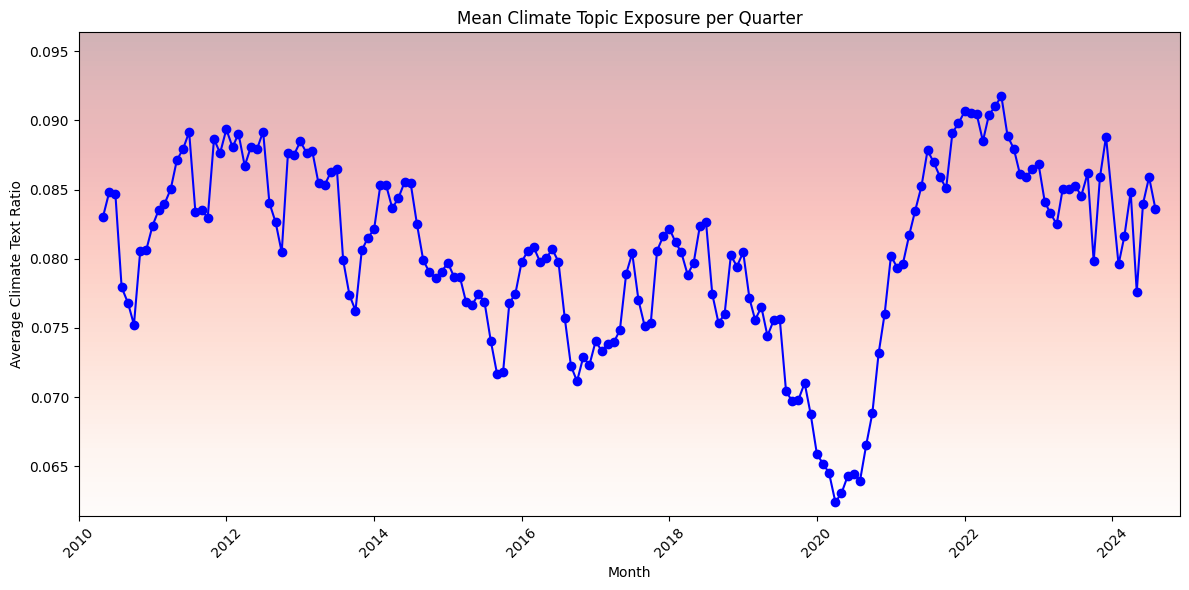

In [19]:
csv_path = root_data+"clim_metrics/ratio/BERT/climate_sentence_ratio_output_full.csv"
plot_climate_ratio_over_time(csv_path, window=9, years=[2010,2024], title="Mean Climate Topic Exposure per Quarter")

#### Show exposures by location

In [20]:
from utils.geographical_risk import show_firm_map_with_ratios

m = show_firm_map_with_ratios(root_path=root_data)

✅ Map saved to /Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/climate_exposure_map.html. Open this file in your browser to view.


## Obtain climate exposure scores

In [4]:
from engle.Z_clim import clim_matrix

root = "/Users/marleendejonge/Desktop/PhD/Projects/ECC transcripts/"

weights = clim_matrix(mask_zeros=False, save=True)

📥 Loading CSV ...
📊 Rank-normalizing factors within each month...
📊 Demeaning (absolute) factors within each month (reversed)...
✅ Saved projected factors to /Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/clim_metrics/Z_clim.csv


In [5]:
import numpy as np

false_tickers = ['05VHQ2 -E', '080LKF -E', '08XM5M -E', '0CV4BY-E', '0GPW6G -E', np.nan]
weights = weights.loc[~weights.ISSUER_TICKER.isin(false_tickers)]

weights['COUNTRY'] = weights['ISSUER_TICKER'].str[-2:]

weights.head(20)

weights.to_csv("/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/clim_metrics/Z_clim1905.csv", index=False)

## Hedging climate change news (Engle et al. (2020))

In [6]:
from engle.hedge_method import run_cross_sectional_factor_regression
import pandas as pd

root_code = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/code/"
root_data = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/"

engle_path = root_data + "hedge_df_engle_full_1905.csv"
factor_path = root_data + "clim_metrics/Z_clim1905.csv"

# # DUMMY DATA
# engle_path = root_data + "dummy/dummy_engle_unbal.csv"
# factor_path = root_data + "dummy/dummy_clim_unbal.csv"

start_year = 2010
end_year = 2018

#### Merge US and EU df

In [7]:
df1 = pd.read_csv("/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/hedge_df_engle_EU_1905.csv")
df2 = pd.read_csv("/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/hedge_df_engle_US_1905.csv")

df_full = pd.concat([df1,df2])

df_full.to_csv("/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/hedge_df_engle_full_1905.csv", index=False)

#### Engle

In [9]:
factor_path = '/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/clim_metrics/VAE_generated_portfolio_clim_weights.csv'

In [10]:
df_engle = pd.read_csv(engle_path)
df_clim = pd.read_csv(factor_path)

In [11]:
df_engle.columns

Index(['ISIN', 'ISSUER_TICKER', 'MONTH', 'TOT_RETURN_INDEX_GROSS_DVDS',
       'PX_TO_BOOK_RATIO', 'month', 'year', 'Stock_Return', 'BOOK_TO_MARKET',
       'STOXX_INDEX', 'Market_Return', 'UMC.ALL', 'WSJ.AR1', 'CHNEG.AR1',
       'MKT_CAP', 'CLIM_RATIO', 'Z_HML', 'Z_MKT', 'Z_SIZE', 'Z_SUS',
       'MKT_SHARE', 'SP_INDEX'],
      dtype='object')

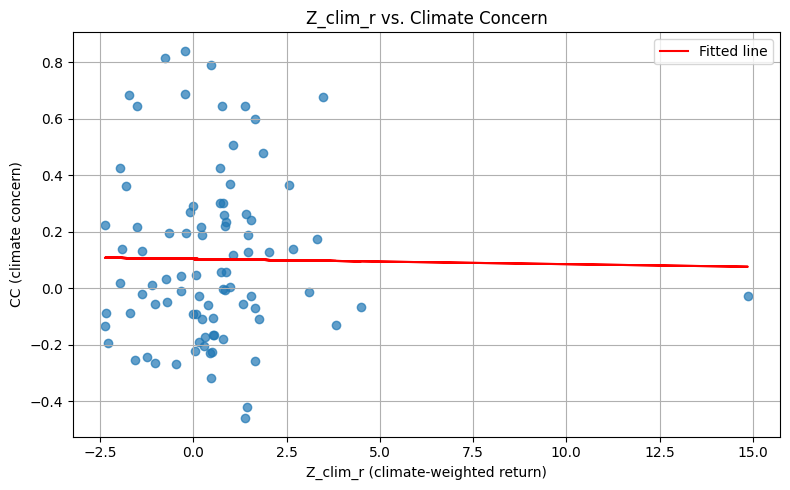

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.2259
Date:                Wed, 18 Jun 2025   Prob (F-statistic):              0.923
Time:                        11:00:28   Log-Likelihood:                -17.047
No. Observations:                  89   AIC:                             44.09
Df Residuals:                      84   BIC:                             56.54
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0916      0.095      0.966      0.3

In [12]:
run_cross_sectional_factor_regression(
    df_engle=df_engle,
    df_clim=df_clim,
    clim_col='WEIGHT',
    concern_col='UMC.ALL',
    start_year=2010,
    end_year=2019
)

In [40]:
from engle.dynamic_engle_torch import run_cross_sectional_factor_regression_torch
from engle.datadict_converter import df_to_torch_data_dict

import pandas as pd

root_code = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/code/"
root_data = "/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/data/"

engle_path = root_data + "hedge_df_engle_full.csv"
factor_path = root_data + "clim_metrics/Z_clim.csv"

df_engle = pd.read_csv(engle_path)

data_dict = df_to_torch_data_dict(df_engle, "UMC.ALL")

run_cross_sectional_factor_regression_torch(
    data_dict=data_dict,
    df_clim=df_clim,
    clim_col='ratio_R',
    concern_col='UMC.ALL',
    start_year=2010,
    end_year=2018
)

ImportError: cannot import name 'run_cross_sectional_factor_regression_torch' from 'engle.dynamic_engle_torch' (/Users/marleendejonge/Library/CloudStorage/OneDrive-UvA/PhD/PhD planning/Papers/PaperI/ECC transcripts/ECC_climate_risk/code/engle/dynamic_engle_torch.py)